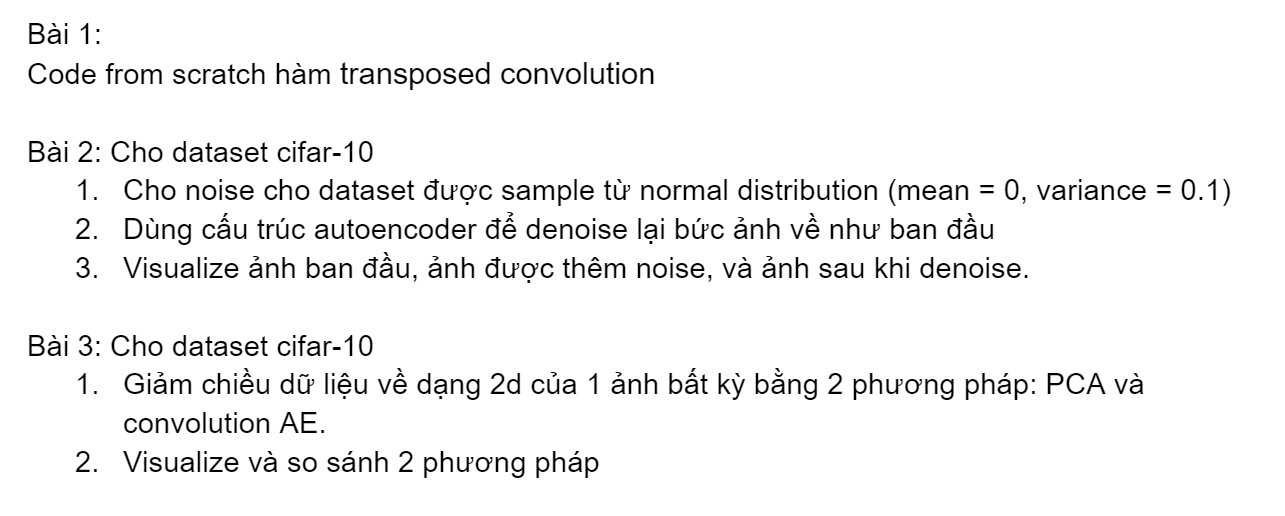

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Ex 1

In [ ]:
def transposed_conv2d(input, weight, bias=None, stride=1, padding=0, output_padding=0, dilation=1):
    # Get input dimensions
    batch_size, in_channels, in_height, in_width = input.size()

    # Get weight dimensions
    out_channels, in_channels, kernel_height, kernel_width = weight.size()

    # Compute output dimensions
    out_height = (in_height - 1) * stride - 2 * padding + dilation * (kernel_height - 1) + output_padding + 1
    out_width = (in_width - 1) * stride - 2 * padding + dilation * (kernel_width - 1) + output_padding + 1

    # Create output tensor
    output = torch.zeros(batch_size, out_channels, out_height, out_width)

    # Perform transposed convolution
    for b in range(batch_size):
        for c_out in range(out_channels):
            for h_out in range(out_height):
                for w_out in range(out_width):
                    for c_in in range(in_channels):
                        for h_k in range(kernel_height):
                            for w_k in range(kernel_width):
                                h_in = h_out + padding - h_k * dilation
                                w_in = w_out + padding - w_k * dilation
                                if (h_in >= 0) and (h_in < in_height) and (w_in >= 0) and (w_in < in_width):
                                    output[b, c_out, h_out, w_out] += input[b, c_in, h_in, w_in] * weight[c_out, c_in, h_k, w_k]

    # Add bias if provided
    if bias is not None:
        output += bias.view(1, -1, 1, 1)

    return output


batch_size = 32
in_channels = 3
out_channels = 2
in_height = 4
in_width = 4
kernel_height = 3
kernel_width = 3
stride = 2
padding = 1
output_padding = 1

input = torch.randn(batch_size, in_channels, in_height, in_width)
weight = torch.randn(out_channels, in_channels, kernel_height, kernel_width)
bias = torch.randn(out_channels)
output = transposed_conv2d(input, weight, bias, stride, padding, output_padding)

# Print the shapes of input and output tensors
print('Input shape:', input.shape)
print('Output shape:', output.shape)

Input shape: torch.Size([32, 3, 4, 4])
Output shape: torch.Size([32, 2, 8, 8])


# Ex 2

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Loss: 0.0146
Epoch [2/10], Loss: 0.0057
Epoch [3/10], Loss: 0.0052
Epoch [4/10], Loss: 0.0049
Epoch [5/10], Loss: 0.0046
Epoch [6/10], Loss: 0.0042
Epoch [7/10], Loss: 0.0037
Epoch [8/10], Loss: 0.0035
Epoch [9/10], Loss: 0.0034


Epoch [10/10], Loss: 0.0033


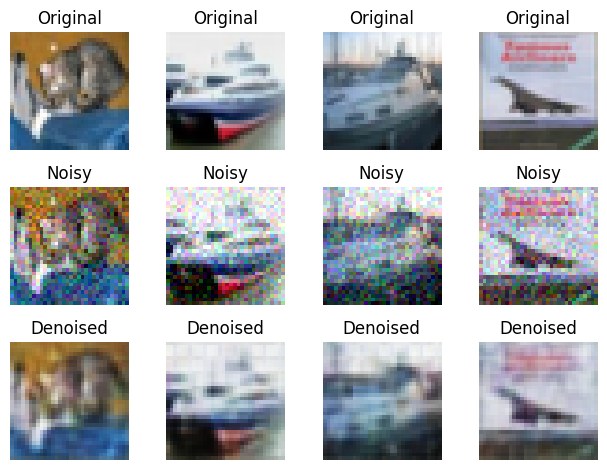

In [ ]:
# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create DataLoader
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create the autoencoder model
model = Autoencoder()

num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the autoencoder


for epoch in range(num_epochs):
    running_loss = 0.0
    for images, _ in train_loader:
        # Add noise to input images
        images = images.to(device)
        noise = torch.randn(images.size()) * 0.1
        noisy_images = images + noise.to(device)

        # Forward pass
        outputs = model(noisy_images.to(device))
        loss = criterion(outputs, images.to(device))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

# Denoise test images
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        # Add noise to test images
        noise = torch.randn(images.size()) * 0.1
        noisy_images = images + noise.to(device)

        # Denoise images
        denoised_images = model(noisy_images.to(device)).cpu()

        # Visualize original, noisy, and denoised images
        for i in range(4):
            original_image = np.transpose(images[i].cpu().numpy(), (1, 2, 0))
            noisy_image = np.transpose(noisy_images[i].cpu().numpy(), (1, 2, 0))
            denoised_image = np.transpose(denoised_images[i].numpy(), (1, 2, 0))

            plt.subplot(3, 4, i+1)
            plt.imshow(original_image)
            plt.title('Original')
            plt.axis('off')

            plt.subplot(3, 4, 4+i+1)
            plt.imshow(noisy_image)
            plt.title('Noisy')
            plt.axis('off')

            plt.subplot(3, 4, 8+i+1)
            plt.imshow(denoised_image)
            plt.title('Denoised')
            plt.axis('off')

        plt.tight_layout()
        plt.show()
        break

# Ex 3

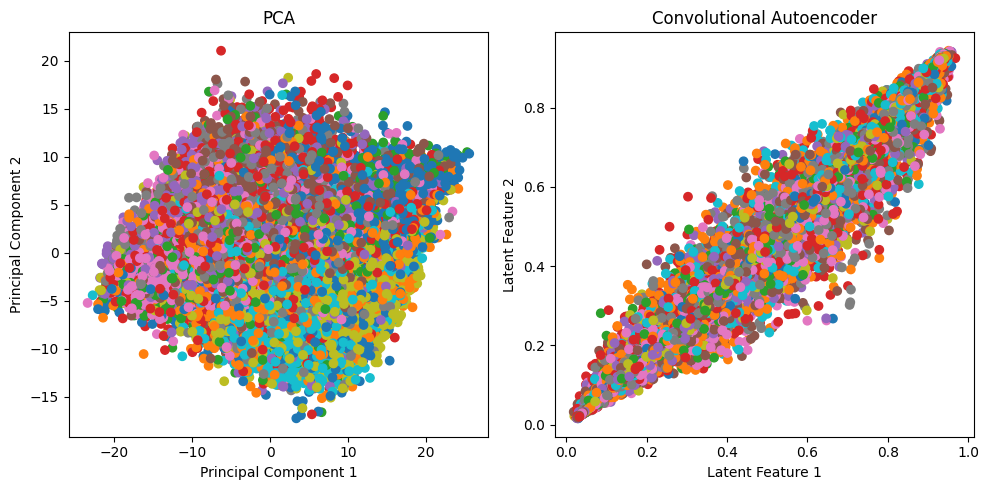

In [ ]:
# Prepare data for PCA
X_pca = []
for i in range(len(train_dataset)):
    image, _ = train_dataset[i]
    flattened_image = image.flatten().numpy()
    X_pca.append(flattened_image)

X_pca = np.stack(X_pca)

# Perform PCA
n_components = 2
pca = PCA(n_components=n_components)
X_pca_transformed = pca.fit_transform(X_pca)

# Prepare data for CAE
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


# Create the Convolutional Autoencoder model
model_cae = Autoencoder()

# Train the Convolutional Autoencoder
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_cae.parameters(), lr=0.001)

for epoch in range(num_epochs):
    for images, _ in train_loader:
        optimizer.zero_grad()
        outputs = model_cae(images.to(device))
        loss = criterion(outputs, images.to(device))
        loss.backward()
        optimizer.step()

# Prepare data for CAE
X_cae = []
for i in range(len(train_dataset)):
    image, _ = train_dataset[i]
    image = image.unsqueeze(0)
    output = model_cae(image.to(device)).cpu()
    flattened_output = output.detach().numpy().flatten()
    X_cae.append(flattened_output)

X_cae = np.stack(X_cae)

# Visualize and compare PCA and CAE results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_pca_transformed[:, 0], X_pca_transformed[:, 1], c=train_dataset.targets, cmap='tab10')
plt.title('PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.subplot(1, 2, 2)
plt.scatter(X_cae[:, 0], X_cae[:, 1], c=train_dataset.targets, cmap='tab10')
plt.title('Convolutional Autoencoder')
plt.xlabel('Latent Feature 1')
plt.ylabel('Latent Feature 2')
plt.tight_layout()
plt.show()